# Demo 2: 
The objectives of this demo are as follows:
- Simulate a single stochastic trajectory of the Ricker model going through a Flip bifurcation
- Compute bootstrapped versions of segments of the time-series over a rolling window
- Compute EWS of the bootstrapped time-series
- Compute and display confidence intervals of the ensemble of EWS
- Run time < 3min

## Import the standard Python libraries and ewstools

In [1]:
# We will require the following standard Python packages for this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# This is the package we use to compute the early warning signals
import ewstools.core as ewstools

## Simulate the Ricker model

Here we simulate a single trajectory of the Ricker model going through a Fold bifurcation. We will use this data to demonstrate the process of computing EWS. Alternatively, you could import your own data here. The importnat thing is that we end up with a Pandas DataFrame indexed by time.

**Set simulation parameters**

In [2]:
dt = 1 # time-step (using 1 since discrete-time system)
t0 = 0 # starting time
tmax = 1000 # end time
tburn = 100 # burn-in period preceding start-time
seed = 0 # random number generation seed (set for reproducibility)

**Define model**

We use the Ricker model with a Holling Type II harvesting term and additive white noise. It is given by
$$ N_{t+1} = N_t e^{(r(1-N_t/K) + \sigma\epsilon_t} ) - F\frac{N_t^2}{N_t^2 + h^2}$$
where $N_t$ is the population size at time $t$, $r$ is the intrinsic growth rate, $K$ is the carrying capacity, $F$ is the maximum rate of harvesting, $h$ is the half saturation constant of the harvesting term, $\sigma$ is the noise amplitude, and $\epsilon_t$ is a normal random variable with zero mean and unit variance.

In [3]:
# Define the model
def de_fun(x,r,k,f,h,xi):
    return x*np.exp(r*(1-x/k)+xi) - f*x**2/(x**2+h**2)

**Set model parameters**

In [4]:
f = 0 # harvesting rate
k = 10 # carrying capacity
h = 0.75 # half-saturation constant of harvesting function
bl = 0.5 # bifurcation parameter (growth rate) low
bh = 2.3 # bifurcation parameter (growth rate) high
bcrit = 2 # bifurcation point (computed using XPPAUT)
sigma = 0.02 # noise intensity
x0 = 0.8 # initial condition

**Initialisation**

In [5]:
# Initialise arrays for time and state values
t = np.arange(t0,tmax,dt)
x = np.zeros(len(t))

# Bifurcation parameter values (increasing linearly in time)
b = pd.Series(np.linspace(bl,bh,len(t)),index=t) # bifurcation parameter values over time (linear increase)

# Compute time at which bifurcation is crossed
tcrit = b[b > bcrit].index[1]

# Array of noise values (normal random variables with variance sigma^2 dt)
dW_burn = np.random.normal(loc=0, scale=sigma*np.sqrt(dt), size = int(tburn/dt)) # burn-in period
dW = np.random.normal(loc=0, scale=sigma*np.sqrt(dt), size = len(t)) # monitored period

**Run simulation**

In [6]:
# Run burn-in period starting from intiial condition x0
for i in range(int(tburn/dt)):
    x0 = de_fun(x0,bl,k,f,h,dW_burn[i])

# State value post burn-in period. Set as starting value.
x[0]=x0

# Run simulation using recursion
for i in range(len(t)-1):
    x[i+1] = de_fun(x[i],b.iloc[i],k,f,h,dW[i])
    # Make sure that state variable stays >= 0
    if x[i+1] < 0:
        x[i+1] = 0
        
# Store array data in a DataFrame indexed by time
sim_data = {'Time': t, 'x': x}
df_traj = pd.DataFrame(sim_data)
df_traj.set_index('Time', inplace=True)

We now have a DataFrame df_traj, with our trajectory, indexed by time. We can check it out with a simple plot, using the command

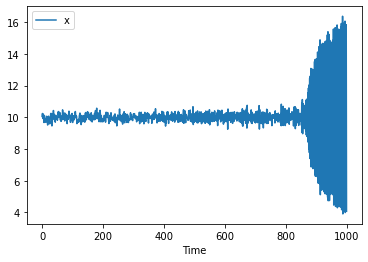

In [7]:
df_traj.plot();

## Bootstrap the time-series over a rolling window



To obtain a more reliable estimate of the statistical metrics that consitute EWS in this system, we bootstrap the detrended time-series within each position of the rolling window. Specifically, we use a block-bootstrapping method where blocks of points are sampled randomly with replacement. The size of the block for each sample is taken from an exponential distribution with a chosen parameter. The block sizes used should be large enough to retain the significant temporal correlations in the time-series. 

**Set bootstrapping parameters**

In [8]:
rw = 0.4 # rolling window
span = 0.5 # Lowess span
block_size = 20 # characteristic size of blocks used to resample time-series
bs_type = 'Stationary' # type of bootstrapping
n_samples = 3 # number of bootstrapping samples to take
roll_offset = 20 # rolling window offset

**Compute block-bootstrapped samples**

We now construct a Dataframe of bootstrapped samples of the time-series, using the function *roll_bootstrap* within the *ewstools* package. Note that documentation of each function can be obtained using help(*function_name*)

In [9]:
df_samples = ewstools.roll_bootstrap(df_traj['x'],
                   span = span,
                   roll_window = rw,
                   roll_offset = roll_offset,
                   upto = tcrit,
                   n_samples = n_samples,
                   bs_type = bs_type,
                   block_size = block_size
                   )

For illustraion, here are 3 bootstrapped samples from the time-series within the rolling window at $t=459$.

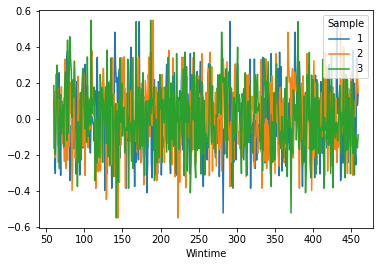

In [10]:
df_samples.loc[459].loc[1:3]['x'].unstack(level=0).plot();

## Compute EWS of the ensemble of bootstrap time-series

Now we send each bootstrapped time-series through *ews_compute*. Note that detrending and extracting segments of the time-series has already been done, so there is no need to smooth the bootstrapped data, or use a rolling window.

**EWS parameters**

In [11]:
ews = ['var','ac','smax','aic']
lags = [1,2,3] # autocorrelation lag times
ham_length = 40 # number of data points in Hamming window
ham_offset = 0.5 # proportion of Hamming window to offset by upon each iteration
pspec_roll_offset = 20 # offset for rolling window when doing spectrum metrics
sweep = 'False' # whether to sweep over optimisation parameters

**Initialisation**

In [12]:
# List to store EWS DataFrames
list_df_ews = []
# List to store power spectra 
list_pspec = []

# Extract time and sample values to loop over
# Time values
tVals = np.array(df_samples.index.levels[0])
# Sample values
sampleVals = np.array(df_samples.index.levels[1])

**Run ews_compute for each bootstrapped sample (takes a few minutes)**

In [13]:
# Loop over time (at end of rolling window)
for t in tVals:
    # Loop over samples
    for sample in sampleVals:
        
        # Extract series for this time and sample number
        series_temp = df_samples.loc[t].loc[sample]['x']
        
        ews_dic = ewstools.ews_compute(series_temp,
                          roll_window = 1, # effectively no rolling window
                          band_width = 1, # effectively no detrending
                          ews = ews,
                          lag_times = lags,
                          upto='Full',
                          ham_length = ham_length,
                          ham_offset = ham_offset,
                          sweep = sweep)
        
        # The DataFrame of EWS
        df_ews_temp = ews_dic['EWS metrics']
        
        # Include columns for sample value and realtime
        df_ews_temp['Sample'] = sample
        df_ews_temp['Time'] = t

        # Drop NaN values
        df_ews_temp = df_ews_temp.dropna()        
        
        # Append list_df_ews
        list_df_ews.append(df_ews_temp)
    
    # Output power spectrum for just one of the samples (ow large file size)
    df_pspec_temp = ews_dic['Power spectrum'][['Empirical']].dropna()
    list_pspec.append(df_pspec_temp)
    
    # Print update
    print('EWS for t=%.2f complete' % t)
        
# Concatenate EWS DataFrames. Index [Realtime, Sample]
df_ews_boot = pd.concat(list_df_ews).reset_index(drop=True).set_index(['Time','Sample'])

df_pspec_boot = pd.concat(list_pspec)

EWS for t=399.00 complete
EWS for t=419.00 complete
EWS for t=439.00 complete
EWS for t=459.00 complete
EWS for t=479.00 complete
EWS for t=499.00 complete
EWS for t=519.00 complete
EWS for t=539.00 complete
EWS for t=559.00 complete
EWS for t=579.00 complete
EWS for t=599.00 complete
EWS for t=619.00 complete
EWS for t=639.00 complete
EWS for t=659.00 complete
EWS for t=679.00 complete
EWS for t=699.00 complete
EWS for t=719.00 complete
EWS for t=739.00 complete
EWS for t=759.00 complete
EWS for t=779.00 complete
EWS for t=799.00 complete
EWS for t=819.00 complete


## Plot EWS with 95% confidence intervals

We use the Seaborn package here to make plots of the ensemble EWS as mean values with 95% confidence intervals.

**Variance**

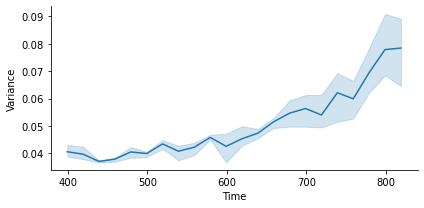

In [14]:
sns.relplot(x='Time', y='Variance',
            data=df_ews_boot.reset_index()[['Time','Variance']],
            kind='line',
            height=3,
            aspect=2);

**Autocorrelation**

In [15]:
# Structure the data for Seaborn
plot_data=df_ews_boot.reset_index()[['Time','Lag-1 AC','Lag-2 AC','Lag-3 AC']].melt(id_vars='Time',
                                                                          value_vars=('Lag-1 AC','Lag-2 AC','Lag-3 AC'),
                                                                          var_name='EWS', 
                                                                          value_name='Magnitude')

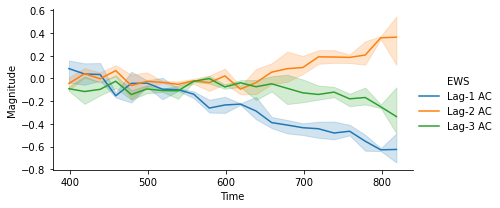

In [16]:
sns.relplot(x='Time', 
            y='Magnitude',
            hue='EWS',
            data=plot_data,
            kind='line',
            height=3,
            aspect=2);

**Smax**

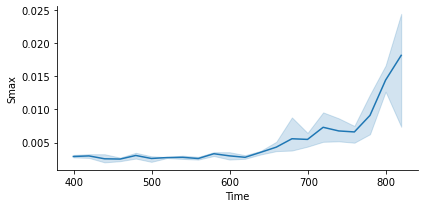

In [17]:
sns.relplot(x='Time', y='Smax',
            data=df_ews_boot.reset_index()[['Time','Smax']],
            kind='line',
            height=3,
            aspect=2);

**AIC weights**

In [18]:
# Structure the data for Seaborn
plot_data=df_ews_boot.reset_index()[['Time','AIC fold','AIC hopf','AIC null']].melt(id_vars='Time',
                                                                          value_vars=('AIC fold','AIC hopf','AIC null'),
                                                                          var_name='EWS', 
                                                                          value_name='Magnitude')

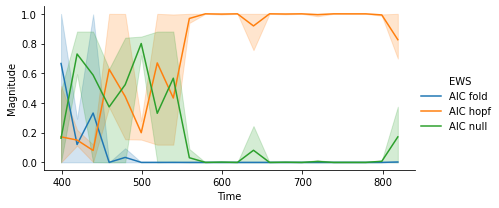

In [19]:
sns.relplot(x='Time', 
            y='Magnitude',
            hue='EWS',
            data=plot_data,
            kind='line',
            height=3,
            aspect=2);